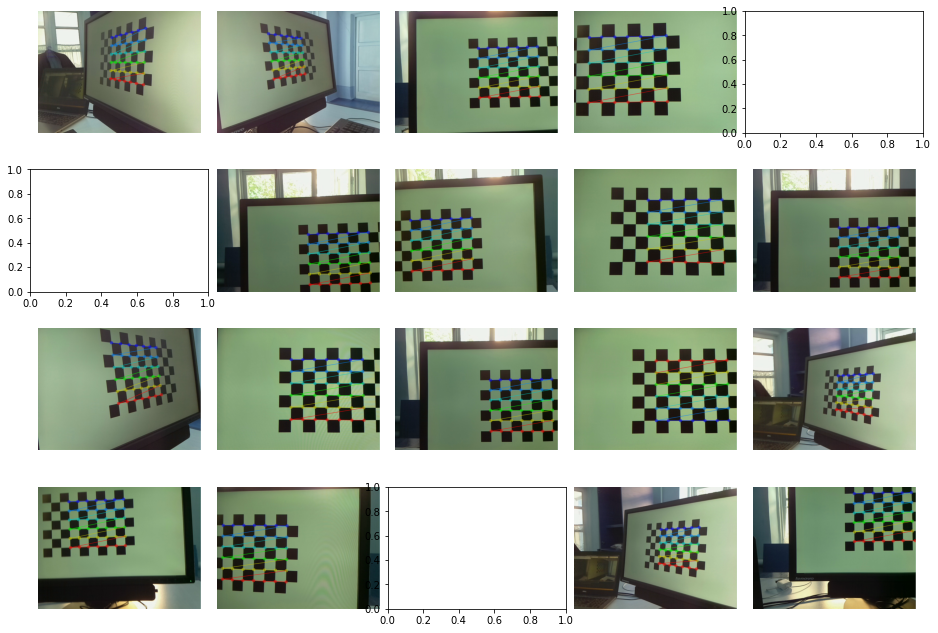

In [62]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('images/calibrate/*')

fig, axs = plt.subplots(4, 5, figsize=(16, 11))
fig.subplots_adjust(hspace=.3, wspace=.003)
axs = axs.ravel()

for i, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7, 6), None)

    # If found, add object points, image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (7, 6), corners2, ret)

        axs[i].axis('off')
        axs[i].imshow(img)

    fig.savefig('images/chessboard-corners', dpi=150)

    if cv.waitKey(1) == ord('q'):
        break

cv.destroyAllWindows()

In [63]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera Matrix:")
print(mtx)
print("\nDistortion Coefficients:")
print(dist)

Camera Matrix:
[[620.0123877    0.         319.13941513]
 [  0.         619.6042525  233.56104872]
 [  0.           0.           1.        ]]

Distortion Coefficients:
[[ 2.69666675e-01 -8.59625702e-01 -2.00813112e-03 -8.11002111e-04
   6.74883835e-01]]


In [64]:
def undistort(img, mtx, dist):
    undist = cv.undistort(img, mtx, dist, None, mtx)
    return undist

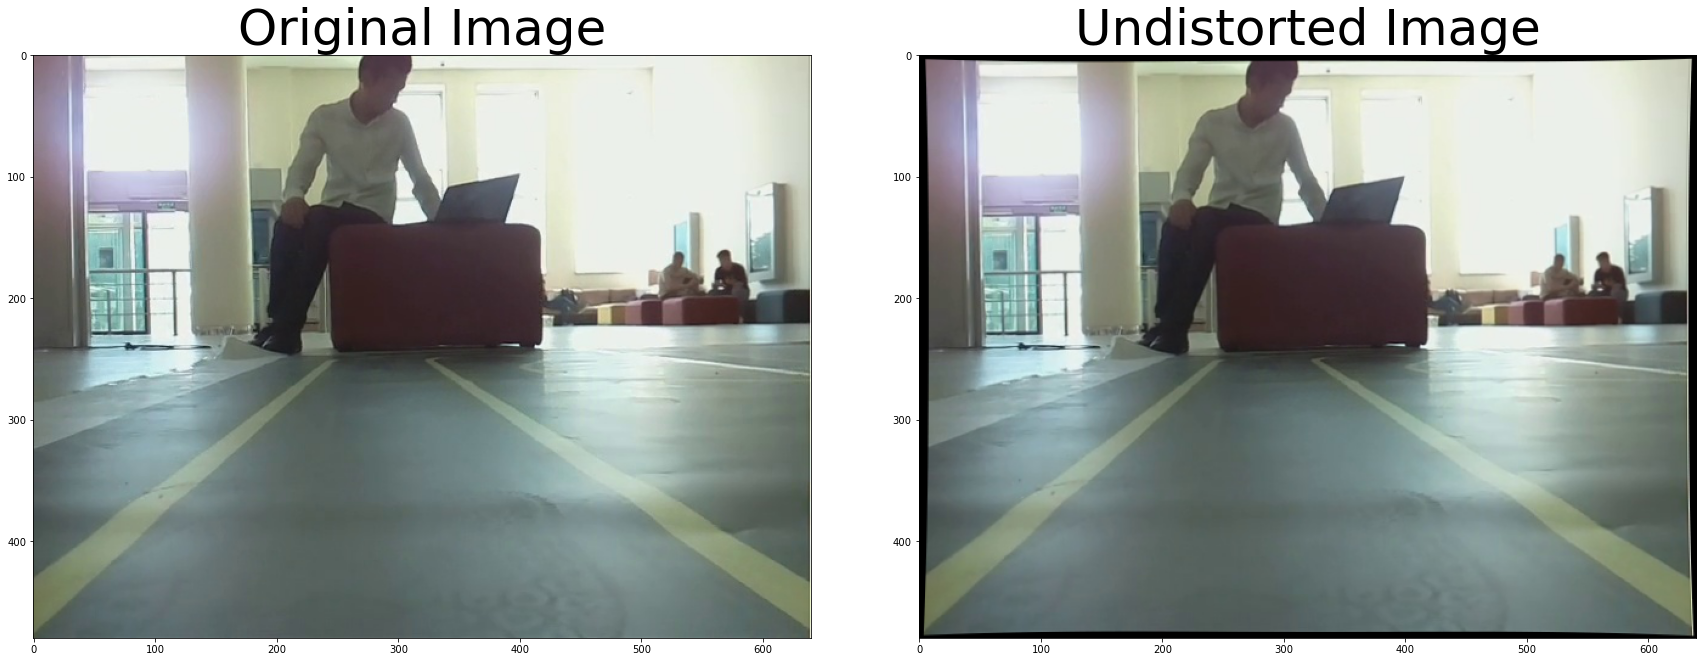

In [65]:
from matplotlib import image as mpimg

fname = 'images/track/track 15:40:23.jpg'

img = mpimg.imread(fname)

# Use the undistort function, with the mtx and dist calculated above
undist = undistort(img, mtx, dist)

### print an example plot of a comparison of a distorted and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [66]:
def add_lines(img, src):
    img2 = np.copy(img)
    color = [255, 0, 0]  # Red
    thickness = 2
    x0, y0 = src[0]
    x1, y1 = src[1]
    x2, y2 = src[2]
    x3, y3 = src[3]
    cv.line(img2, (x0, y0), (x1, y1), color, thickness)
    cv.line(img2, (x1, y1), (x2, y2), color, thickness)
    cv.line(img2, (x2, y2), (x3, y3), color, thickness)
    cv.line(img2, (x3, y3), (x0, y0), color, thickness)
    return img2

In [67]:
def add_points(img, src):
    img2 = np.copy(img)
    color = [255, 0, 0]  # Red
    thickness = -1
    radius = 3
    x0, y0 = src[0]
    x1, y1 = src[1]
    x2, y2 = src[2]
    x3, y3 = src[3]

    cv.circle(img2, (x0, y0), radius, color, thickness)
    cv.circle(img2, (x1, y1), radius, color, thickness)
    cv.circle(img2, (x2, y2), radius, color, thickness)
    cv.circle(img2, (x3, y3), radius, color, thickness)
    return img2

In [68]:
# Points for the original image
src = np.float32([
    [0, 410],
    [110, 330],
    [470, 330],
    [600, 400]
])
src_int = np.int32(src)

# Points for the new image
dst = np.float32([
    [220, 480],
    [220, 0],
    [640 - 220, 0],
    [640 - 220, 480]
])
dst_int = np.int32(dst)


def warper(img):
    # Compute and apply perspective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv.getPerspectiveTransform(src, dst)
    warped = cv.warpPerspective(img, M, img_size, flags=cv.INTER_NEAREST)  # keep same size as input image

    return warped


def unwarp(img):
    # Compute and apply inverse perspective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv.getPerspectiveTransform(dst, src)
    unwarped = cv.warpPerspective(img, Minv, img_size, flags=cv.INTER_NEAREST)

    return unwarped

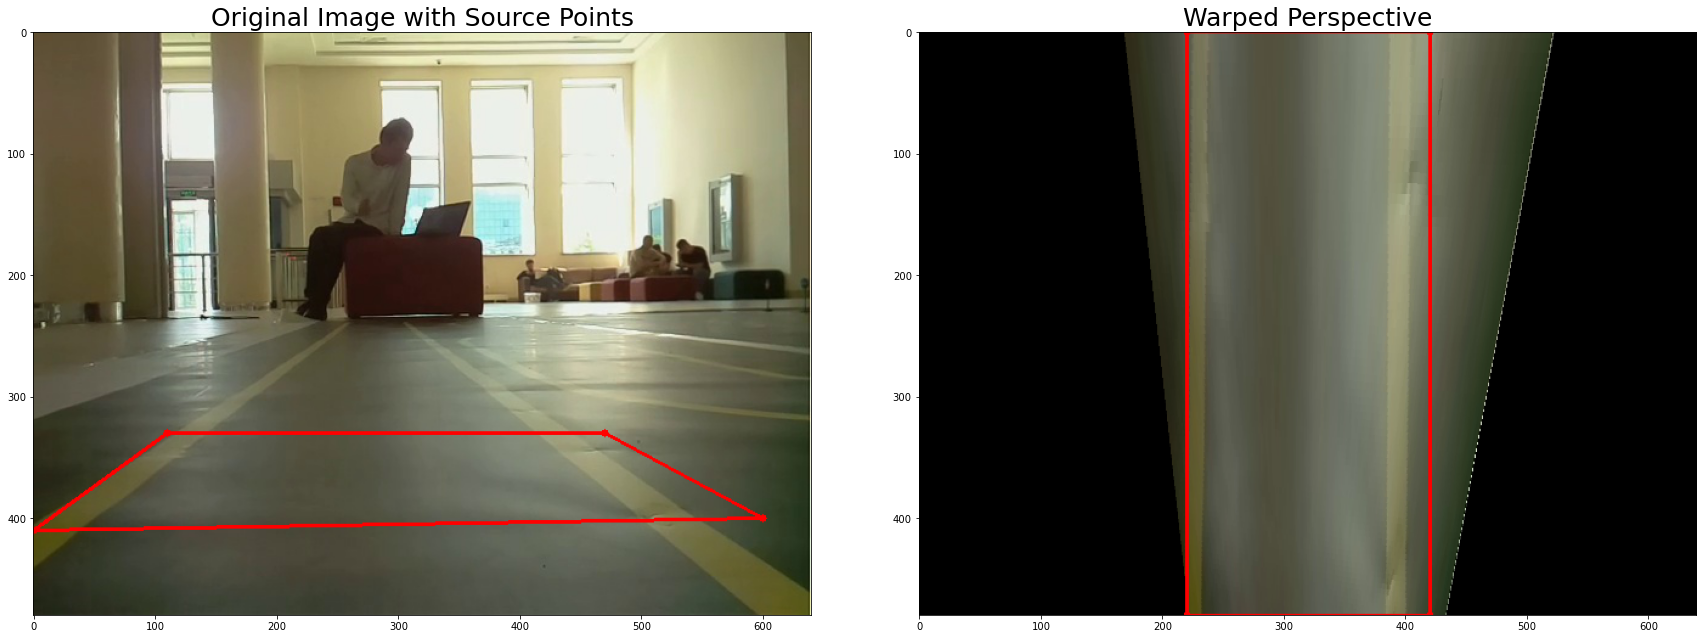

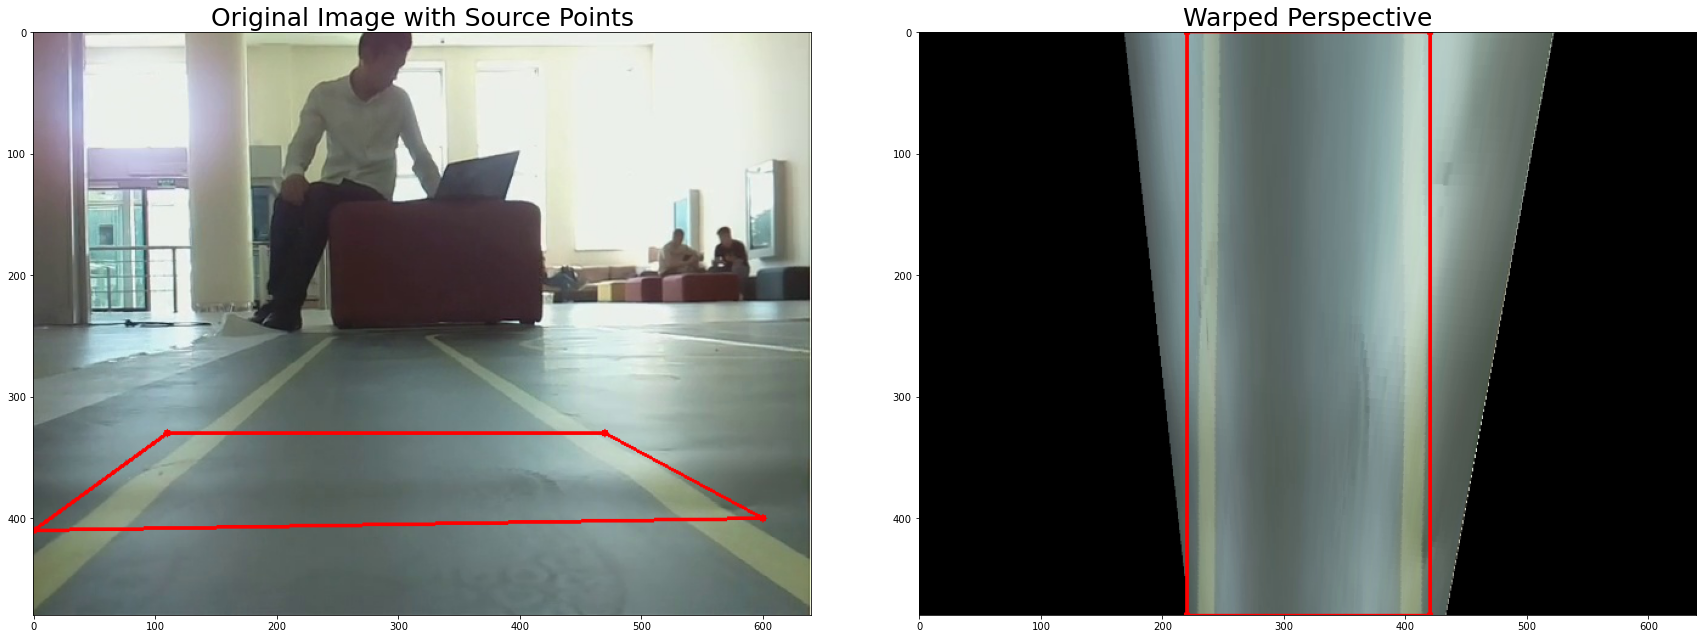

In [69]:
### get the straight test images from the track folder
images = glob.glob('images/track/track 15:40:*.jpg')

for fname in images:
    img = mpimg.imread(fname)

    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)

    # warp the image
    warped = warper(undist)

    # add the points to the og and warped images
    dst_points_warped = add_points(warped, dst_int)
    dst_points_warped = add_lines(dst_points_warped, dst_int)
    src_points_img = add_points(img, src_int)
    src_points_img = add_lines(src_points_img, src_int)

    ### Plot the source points on the original image and the warped image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(src_points_img)
    ax1.set_title('Original Image with Source Points', fontsize=25)
    ax2.imshow(dst_points_warped)
    ax2.set_title('Warped Perspective', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
